# DC1 Data Validation with Dask

This notebook explores a few simple validation tests for the DC1 catalog data using dask. For on introduction to accessing DC1 data with `dask`, see the previous notebook [here](./DC1_Dask_Access.ipynb). To setup your kernel to run this notebook, use [lsst-kernel.sh](./lsst-kernel.sh).

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 5)

import os,sys
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import dask.dataframe as dd

print(sys.version)
print("numpy: %s"%np.__version__)
print("pandas: %s"%pd.__version__)
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib
3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy: 1.13.1
pandas: 0.20.3


Read the 15 Gbyte dataframe located in a HDF5 data file into a dask dataframe.  This will allow us to do out of memory operations.

In [2]:
%%time
file_path = '/global/projecta/projectdirs/lsst/groups/SSim/DC1'
df = dd.read_hdf(os.path.join(file_path,'coadd-DC1-imsim-undithered.hdf'), key='*')

CPU times: user 19.7 s, sys: 303 ms, total: 20 s
Wall time: 20 s


This will show us all of the columns of the dask dataframe

In [3]:
df.info();

<class 'dask.dataframe.core.DataFrame'>
Columns: 298 entries, id to psfMag
dtypes: bool(136), float32(8), float64(147), int32(5), int64(2)

Now do a dask operation and put the results (which will fit in memory) into a normal pandas data frame.  First specify which columns we would like.

In [4]:
requested_columns = ['coord_ra','coord_dec', 
                     'base_PsfFlux_flux','base_PsfFlux_fluxSigma',
                     'modelfit_CModel_flux']

Have dask read the file and move it into a pandas dataframe with the columns we want. Remove objects that do not have measured PSF and model fluxes.

In [5]:
%%time
selected = df[requested_columns].compute()
measured = (selected['base_PsfFlux_flux'] > 0) & (selected['modelfit_CModel_flux'] > 0)
selected = selected[measured]
print(selected.shape)

(9459539, 5)
CPU times: user 25.3 s, sys: 12.5 s, total: 37.9 s
Wall time: 59.7 s


The hdf5 files are organized with each processing "patch" stored in a separate "extension". To grab the data associated with a specific patch (10,10), we can load it directly from the files.

In [6]:
%%time
df_patch = dd.read_hdf(os.path.join(file_path,'coadd-DC1-imsim-undithered.hdf'), key='*_10_10_*')
selected_patch = df_patch[requested_columns].compute()
measured = (selected_patch['base_PsfFlux_flux'] > 0) & (selected_patch['modelfit_CModel_flux'] > 0)
selected_patch = selected_patch[measured]
print(selected_patch.shape)

(72497, 5)
CPU times: user 1.7 s, sys: 154 ms, total: 1.85 s
Wall time: 5.06 s


Now let's calculate some validation quantities. Note the warning for invalid flux values (flux = 0).

In [7]:
selected = selected[selected['base_PsfFlux_flux'] > 0]
flux_mag0 = 63095734448.0194
magnitude = -2.5*log10(selected['base_PsfFlux_flux']/flux_mag0)

Text(0,0.5,'$N(r)$')

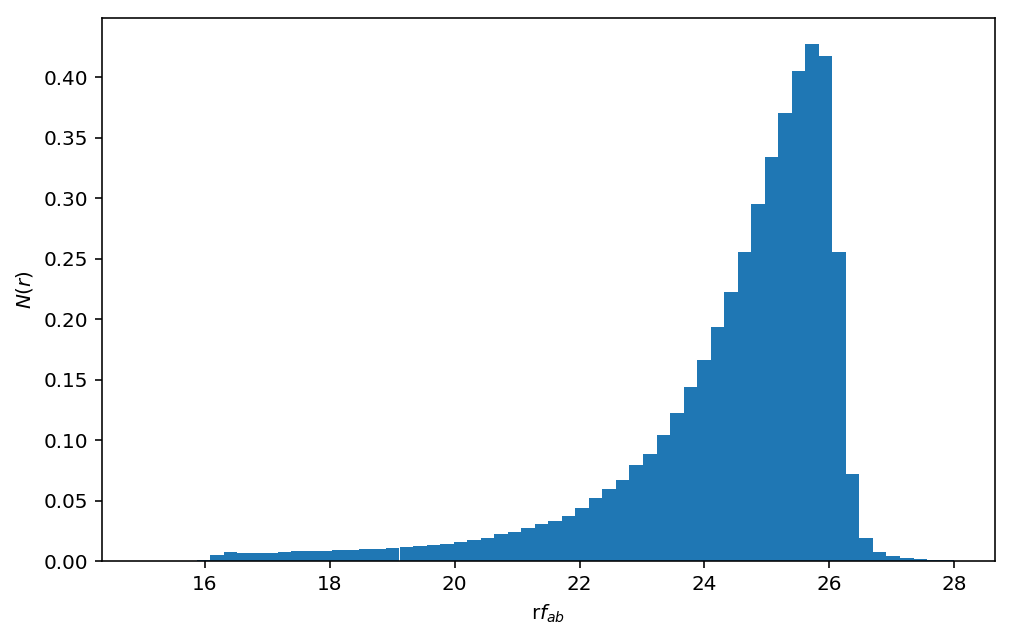

In [8]:
plt.hist(np.nan_to_num(magnitude),range=(15,28),bins=60,normed=True)
plt.xlabel(r'r$f_{ab}$')
plt.ylabel(r'$N(r)$')

Plot the sky locations.  First for the whole dataset:

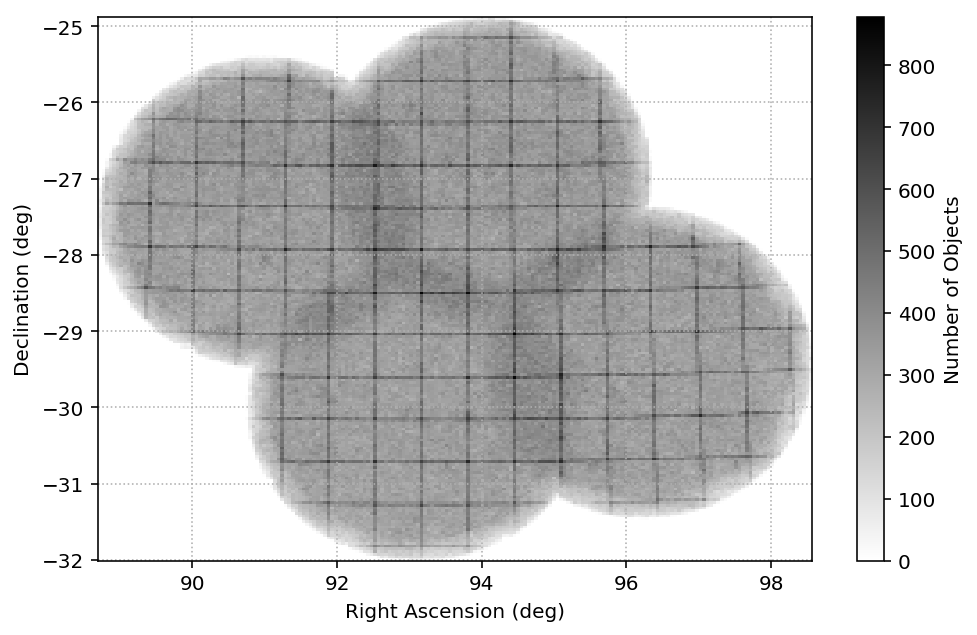

In [9]:
ra  = np.degrees(selected['coord_ra'])
dec = np.degrees(selected['coord_dec'])

#plt.scatter(ra, dec, marker='.',color='k')
plt.hist2d(ra, dec, bins=200,cmap='gray_r')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.grid(ls=':')
plt.colorbar(label='Number of Objects')

And now for just the selected patch 10,10

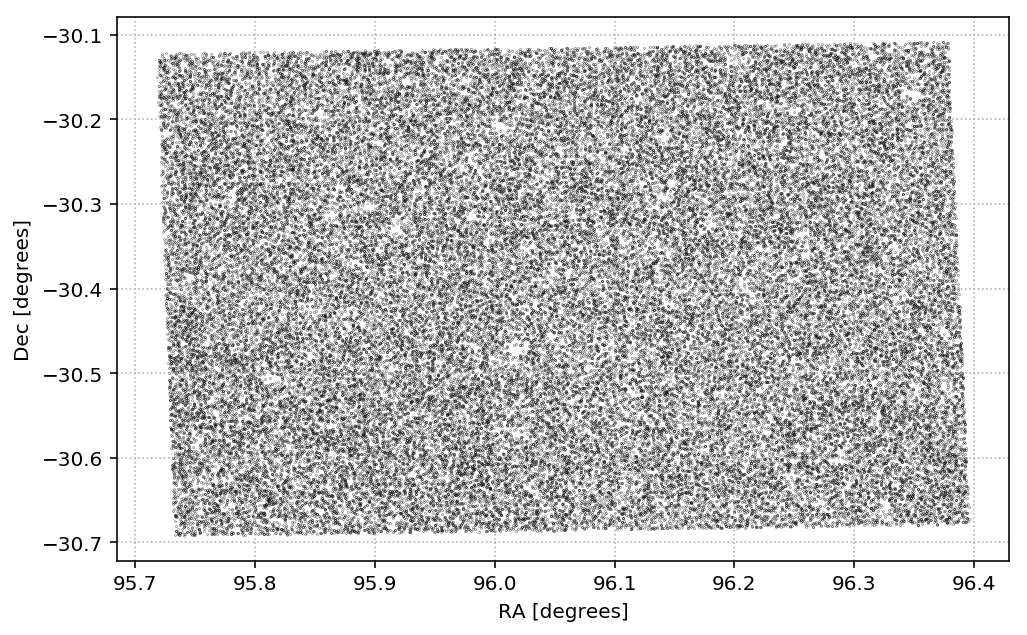

In [10]:
ra  = np.degrees(selected_patch['coord_ra'])
dec = np.degrees(selected_patch['coord_dec'])

plt.scatter(ra, dec, marker='.', s=0.1, color='k')
#plt.hist2d(ra, dec, bins=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.grid(ls=':')

Now let's overlay them!

Text(0,0.5,'Declination (deg)')

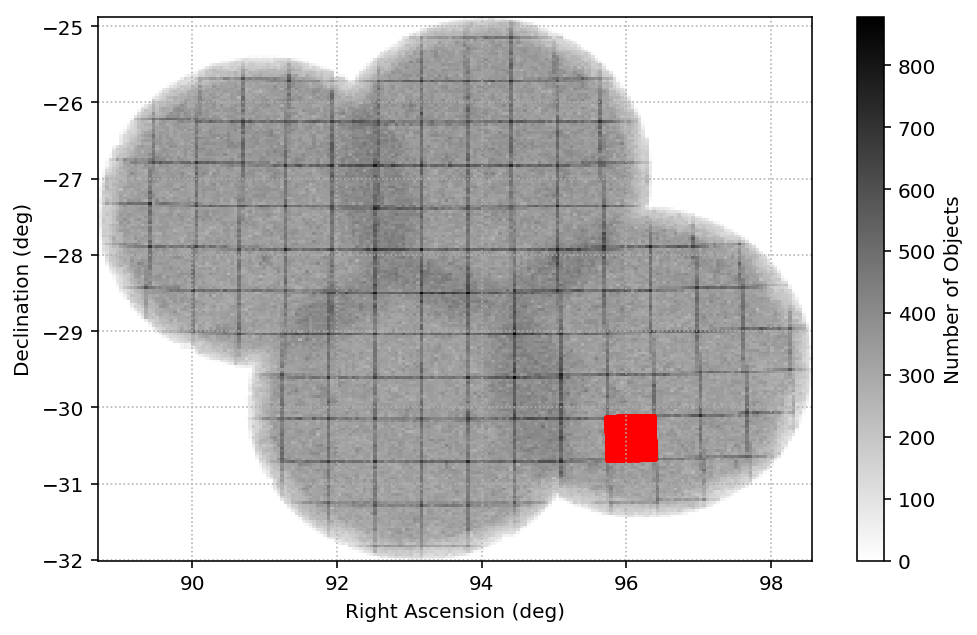

In [11]:
ra  = np.degrees(selected['coord_ra'])
dec = np.degrees(selected['coord_dec'])

ra_patch  = np.degrees(selected_patch['coord_ra'])
dec_patch = np.degrees(selected_patch['coord_dec'])

#plt.scatter(ra, dec, marker='.',color='k')
plt.hist2d(ra, dec, bins=200, cmap='gray_r')
plt.colorbar(label='Number of Objects')
plt.grid(ls=':')

plt.scatter(ra_patch, dec_patch, marker='.',color='r',s=3)
#plt.hist2d(ra, dec, bins=200)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')

Now we would like to plot a very simple single band star galaxy seperator.  This is based on the definition in:

http://www.sdss3.org/dr8/algorithms/classify.php

Which defines extended objects as those for which:

psfMag - cmodelMag > 0.145

In [12]:
flux_mag0 = 63095734448.0194
psfMag = -2.5*log10(selected['base_PsfFlux_flux']/flux_mag0)
cmodelMag = -2.5*log10(selected['modelfit_CModel_flux']/flux_mag0)

objectType = psfMag - cmodelMag

Text(0,0.5,'Objects/bin')

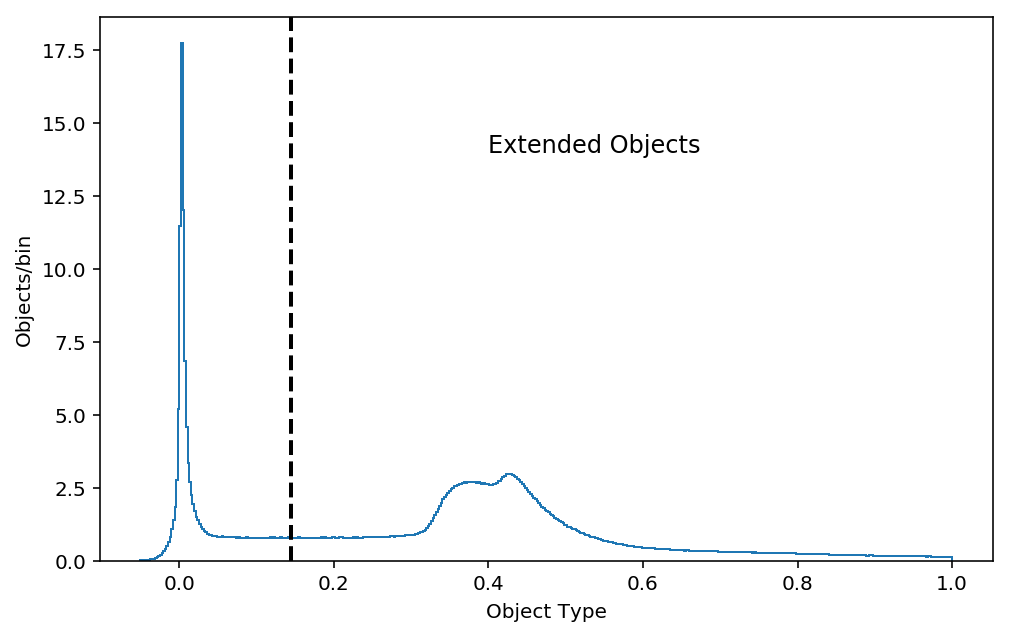

In [13]:
plt.hist(objectType, range=(-0.05,1.0), bins=500, histtype='step',normed=True)
plt.axvline(.145, color='k', linestyle='--', linewidth=2)
plt.text(0.4, 14, "Extended Objects", fontsize=12)
plt.xlabel("Object Type")
plt.ylabel("Objects/bin")

Text(0,0.5,'Object Type')

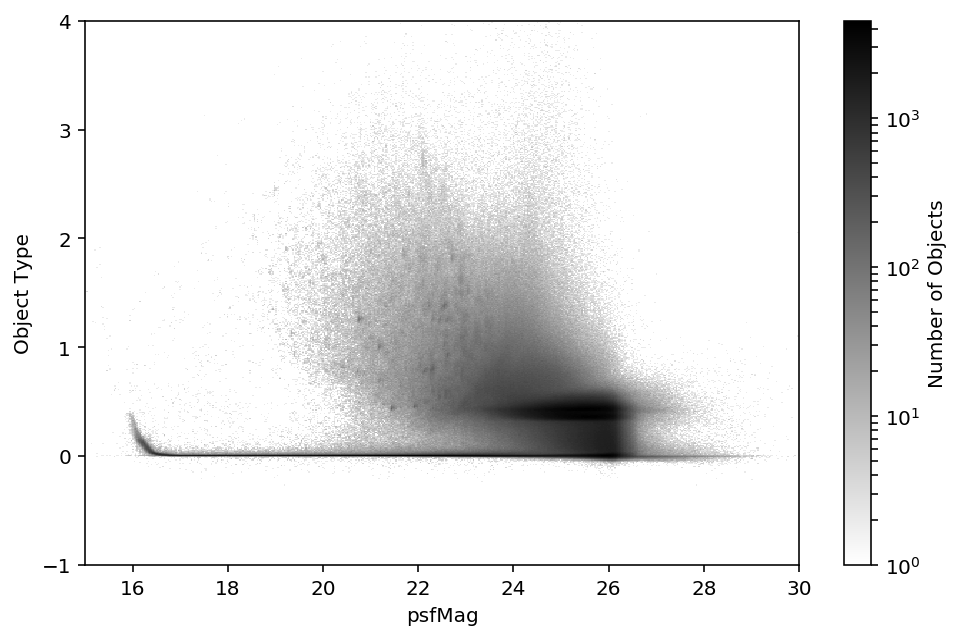

In [14]:
#plt.scatter(psfMag, objectType, s=.01, marker=".", color='k')
plt.hist2d(psfMag, objectType, range=[[15,30],[-1,4]], bins=500, cmap='gray_r', norm=LogNorm())
plt.colorbar(label="Number of Objects")
plt.xlabel("psfMag")
plt.ylabel("Object Type")

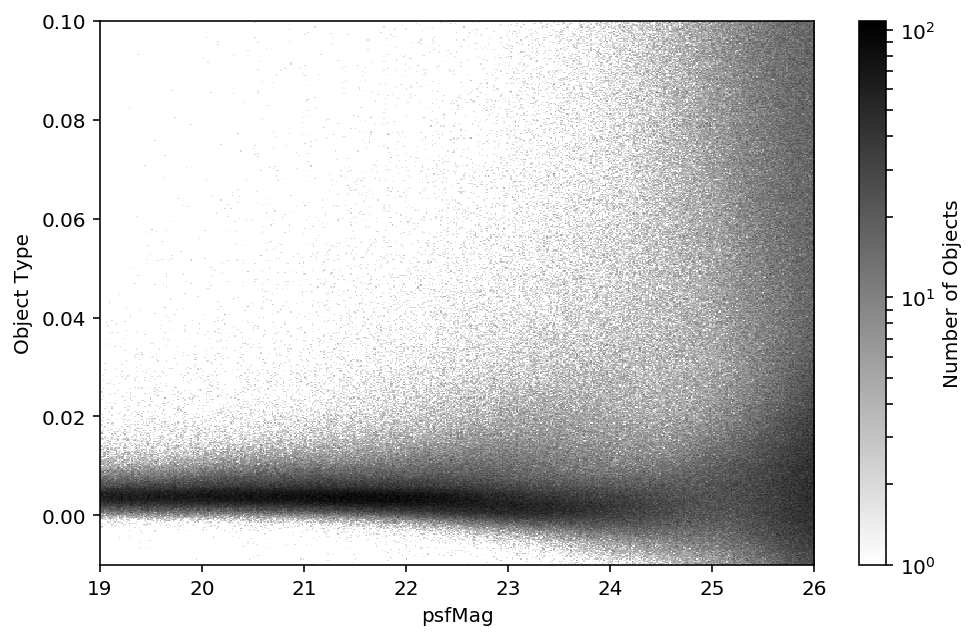

In [15]:
#plt.scatter(psfMag, objectType, s=.01, marker=".", color='k')
plt.hist2d(psfMag, objectType, range=[[19,26],[-0.01,0.10]], bins=500, cmap='gray_r', norm=LogNorm())
plt.colorbar(label="Number of Objects")
plt.xlabel("psfMag")
plt.ylabel("Object Type")

plt.xlim(19,  26)
plt.ylim(-0.01, 0.10);